In [ ]:
!pip install https://github.com/neuropsychology/neurokit/zipball/master

     | 198.6MB 1.1MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for neurokit2: filename=neurokit2-0.0.42-cp36-none-any.whl size=985199 sha256=f23c9f75abcae92006156d64ce89cfa941a914166c3486d14141142d1d585760
  Stored in directory: /tmp/pip-ephem-wheel-cache-ag1k716z/wheels/96/b4/4a/5737e93a6740c234539e1fccf52cc0a868c42ae1c667dbefc6
Successfully built neurokit2


In [ ]:
!pip install scipy

In [ ]:
!pip install tsaug

In [ ]:
import numpy as np
import random
import pandas as pd

import neurokit2 as nk
import tsaug
from scipy import signal

import matplotlib.pyplot as plt


## Data Augmentation 

In [ ]:
# detect all peaks 
def peaks_detected(ecg, sampling_rate=1000):

  # R peak
  _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=1000)
  # PQST peak
  signals, waves = nk.ecg_delineate(ecg, rpeaks, 
                                    sampling_rate=1000, method='peak')
  # append all peaks
  peaks = {}
  peaks.update(rpeaks)
  peaks.update(waves)
  
  return peaks


# get segment
def get_segments(peaks, p1='ECG_R_Peaks', p2='ECG_T_Peaks'):
  p1_loc = peaks[p1]
  p2_loc = peaks[p2]

  # in case p1_loc[0] > p2_loc[0]
  if p1_loc[0] > p2_loc[0]:
    p1_loc = p1_loc[:-1]
    p2_loc = p2_loc[1:]
  else:
    p1_loc = p1_loc
    p2_loc = p2_loc

  # segment position
  segments = []
  for i,j in list(zip(p1_loc, p2_loc)):
    _seg = list(range(i,j))
    segments.append(_seg)

  return segments


In [ ]:
#===== data augmentation =====#
# slope
def segment_aug_slope(ecg, segments, frac=0.9):

  new_ecg = ecg.copy()
  # add slope
  for i in range(len(segments)):

    # generate linear slope
    length = int(len(ecg[segments[i]])*frac)
    line = np.linspace(ecg[segments[i]][0]*0.5, 0, num=length)
    
    # add linear to original data
    _aug = new_ecg[segments[i]]
    _aug[_aug.shape[0]-length:] += abs(line)


    new_ecg[segments[i]] = _aug
  
  return new_ecg


In [ ]:
# normal ecg
ecg = nk.ecg_simulate(duration=10, sampling_rate=1000, noise=0, method='ecgsyn', 
                      heart_rate=60)


In [ ]:
# flatten segment : 
## S-T, T-P scaled down value or replace with 0
## get st_segment, tp_segment
peaks = peaks_detected(ecg, sampling_rate=1000)
st_segments = get_segments(peaks, p1='ECG_S_Peaks', p2='ECG_T_Peaks')
tp_segments = get_segments(peaks, p1='ECG_T_Peaks', p2='ECG_P_Peaks') ## ERROR: T แรกมาหลัง P



975 1254
1254 1789


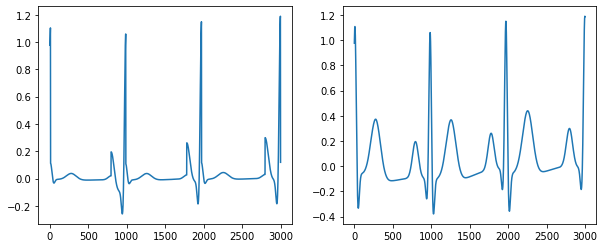

In [ ]:
# flatten 
new_ecg = ecg.copy()

# ST scaled
for i in range(len(st_segments)):
  _aug = new_ecg[st_segments[i]]
  _aug = _aug*0.1

  new_ecg[st_segments[i]] = _aug

# TP scaled
for i in range(len(tp_segments)):
  _aug = new_ecg[tp_segments[i]]
  _aug = _aug*0.1

  new_ecg[tp_segments[i]] = _aug


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(new_ecg[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("aug")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(ecg[3001:6001])
ax2.set(ylim=(-1.5, 1.5))
axs.set_title("normal")

In [ ]:
# implementation flatten_iso
def segment_aug_flatten(ecg, segments):

  new_ecg = ecg.copy()

  # flatten
  for i in range(len(segments)):
    _aug = new_ecg[segments[i]]
    _aug = _aug*0.1

    new_ecg[segments[i]] = _aug

  return new_ecg


Text(0.5, 1.0, 'normal')

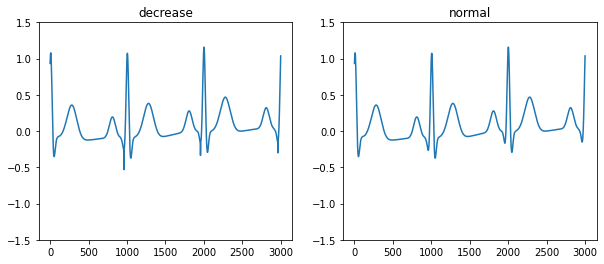

In [ ]:
# diphasis : deep Q before flip
ecg = nk.ecg_simulate(duration=10, sampling_rate=1000, noise=0, method='ecgsyn', 
                      heart_rate=60)

peaks = peaks_detected(ecg, sampling_rate=1000)
q_peaks = peaks['ECG_Q_Peaks']


# decrease Q
new_ecg = ecg.copy()

_aug = ecg[q_peaks]
_aug = _aug*2

new_ecg[q_peaks] = _aug


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(new_ecg[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("decrease")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(ecg[3001:6001])
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("normal")

## simulate v1 - v4

In [ ]:
#===== setting =====#
duration = 10
sampling_rate = 1000
noise = 0
method = 'ecgsyn'
heart_rate = 60

In [ ]:
#===== generate ecg =====#
ecg = nk.ecg_simulate(duration=duration, 
                      sampling_rate=sampling_rate, 
                      noise=noise, 
                      heart_rate=heart_rate,
                      method=method)


In [ ]:
# ecg_v1 : flatten + scaled + flip
def generate_ecg_v1(ecg, st_segments, tp_segments):

  new_ecg = ecg.copy()
  # augmentation
  ecg_v1 = segment_aug_flatten(ecg, st_segments)
  ecg_v1 = segment_aug_flatten(ecg_v1, tp_segments)
  # flip + scaled
  ecg_v1 = ecg_v1*-1*0.3

  return ecg_v1


Text(0.5, 1.0, 'v1')

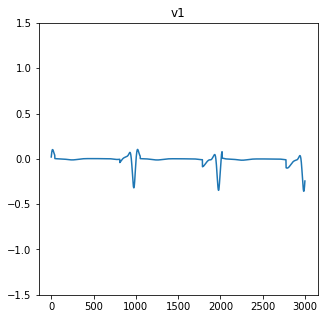

In [ ]:
tmp = generate_ecg_v1(ecg, st_segments, tp_segments)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(tmp[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v1")

In [ ]:
# ecg_v2 : decrease Q + flip_qrs
def generate_ecg_v2(ecg, q_peaks, qrs_segments):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  # decrease Q 
  _aug1 = new_ecg[q_peaks]
  _aug1 = _aug1*2
  new_ecg[q_peaks] = _aug1
  # flip_qrs
  for i in range(len(qrs_segments)):
    _aug2 = new_ecg[qrs_segments[i]]
    _aug2 = _aug2*-1

    new_ecg[qrs_segments[i]] = _aug2

  return new_ecg


Text(0.5, 1.0, 'v2')

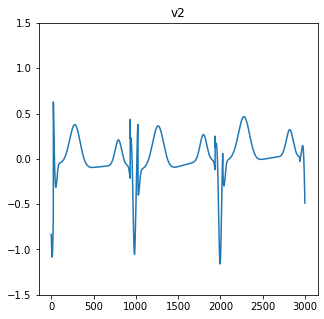

In [ ]:
tmp = generate_ecg_v2(ecg, q_peaks, qrs_segments)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(tmp[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v2")

In [ ]:
# v3 : decrease Q + flip + scaled
def generate_ecg_v3(ecg, q_peaks, qrs_segments):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  # decrease Q 
  _aug1 = new_ecg[q_peaks]
  _aug1 = _aug1*2
  new_ecg[q_peaks] = _aug1
  # flip_qrs
  for i in range(len(qrs_segments)):
    _aug2 = new_ecg[qrs_segments[i]]
    _aug2 = _aug2*-1

    new_ecg[qrs_segments[i]] = _aug2
  # scaled
  new_ecg = new_ecg*0.5

  return new_ecg

Text(0.5, 1.0, 'v3')

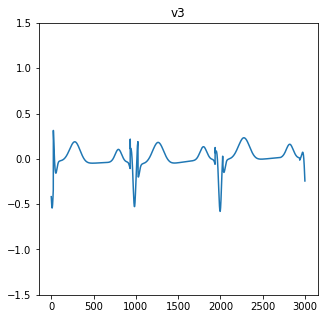

In [ ]:
tmp = generate_ecg_v3(ecg, q_peaks, qrs_segments)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(tmp[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v3")

In [ ]:
# ecg_v4 : decrease S + scaled
def generate_ecg_v4(ecg):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  new_ecg = new_ecg*0.5

  return new_ecg
  

Text(0.5, 1.0, 'v4')

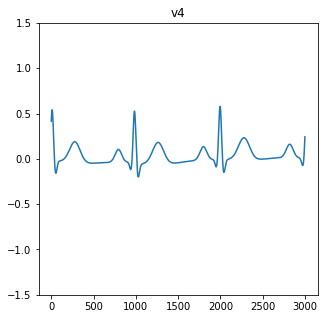

In [ ]:
tmp = generate_ecg_v4(ecg)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(tmp[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v4")

## simulate ST-elevation

In [ ]:
#===== setting =====#
duration = 10
sampling_rate = 1000
noise = 0
method = 'ecgsyn'
heart_rate = 60

In [ ]:
#===== generate ecg =====#
ecg = nk.ecg_simulate(duration=duration, 
                      sampling_rate=sampling_rate, 
                      noise=noise, 
                      heart_rate=heart_rate,
                      method=method)


In [ ]:
#===== get morphology information =====#
peaks = peaks_detected(ecg, sampling_rate=1000)

st_segments = get_segments(peaks, p1='ECG_S_Peaks', p2='ECG_T_Peaks')
tp_segments = get_segments(peaks, p1='ECG_T_Peaks', p2='ECG_P_Peaks') 

q_peaks = peaks['ECG_Q_Peaks']
qrs_segments = get_segments(peaks, p1='ECG_Q_Peaks', p2='ECG_S_Peaks')

rst_segments = get_segments(peaks, p1='ECG_R_Peaks', p2='ECG_T_Peaks')

In [ ]:
# v1_ste
def generate_ecg_v1(ecg, st_segments, tp_segments, pattern='normal', **kwargs):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  # flatten
  ecg_v1 = segment_aug_flatten(new_ecg, st_segments)
  ecg_v1 = segment_aug_flatten(ecg_v1, tp_segments)


  #===== pattern =====#
  if pattern == 'normal':
    ecg_v1 = ecg_v1*-1*0.3
    return ecg_v1
  else :
    rst_segments = kwargs.get('rst_segments', None)
    ecg_v1 = ecg_v1*-1*0.3
    ecg_v1_ste = segment_aug_slope(ecg_v1, segments=rst_segments)
    return ecg_v1_ste


Text(0.5, 1.0, 'v1_ste')

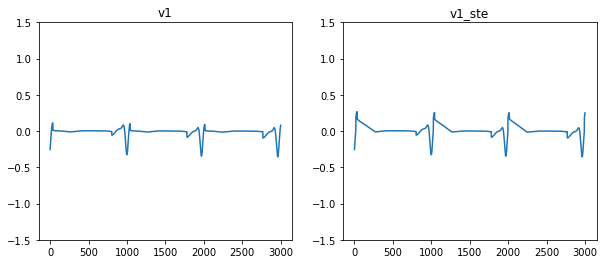

In [ ]:
tmp1 = generate_ecg_v1(ecg, st_segments, tp_segments, pattern='normal')
tmp2 = generate_ecg_v1(ecg, st_segments, tp_segments, 
                      pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(tmp1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v1")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(tmp2[3001:6001])
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v1_ste")


In [ ]:
# ecg_v2 : decrease Q + flip_qrs
def generate_ecg_v2(ecg, q_peaks, qrs_segments, pattern='normal', **kwargs):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  # decrease Q 
  _aug1 = new_ecg[q_peaks]
  _aug1 = _aug1*2
  new_ecg[q_peaks] = _aug1
  # flip_qrs
  for i in range(len(qrs_segments)):
    _aug2 = new_ecg[qrs_segments[i]]
    _aug2 = _aug2*-1

    new_ecg[qrs_segments[i]] = _aug2

  #===== pattern =====#
  if pattern == 'normal':
    ecg_v2 = new_ecg
    return ecg_v2
  else :
    rst_segments = kwargs.get('rst_segments', None)
    ecg_v2 = new_ecg
    ecg_v2_ste = segment_aug_slope(ecg_v2, segments=rst_segments)
    return ecg_v2_ste


Text(0.5, 1.0, 'v2_ste')

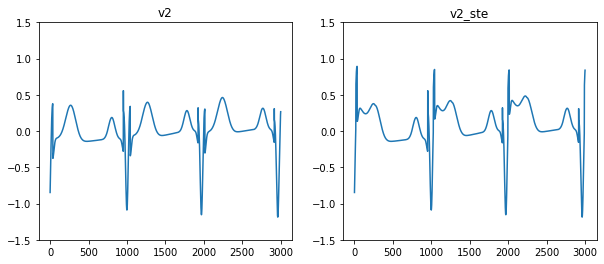

In [ ]:
tmp1 = generate_ecg_v2(ecg, q_peaks, qrs_segments, 
                       pattern='normal')
tmp2 = generate_ecg_v2(ecg, q_peaks, qrs_segments, 
                       pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(tmp1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v2")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(tmp2[3001:6001])
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v2_ste")


In [ ]:
# ecg_v3 : decrease Q + flip + scaled
def generate_ecg_v3(ecg, q_peaks, qrs_segments, pattern='normal', **kwargs):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  # decrease Q 
  _aug1 = new_ecg[q_peaks]
  _aug1 = _aug1*2
  new_ecg[q_peaks] = _aug1
  # flip_qrs
  for i in range(len(qrs_segments)):
    _aug2 = new_ecg[qrs_segments[i]]
    _aug2 = _aug2*-1

    new_ecg[qrs_segments[i]] = _aug2
  # scaled
  new_ecg = new_ecg*0.5

  #===== pattern =====#
  if pattern == 'normal':
    ecg_v3 = new_ecg
    return ecg_v3
  else :
    rst_segments = kwargs.get('rst_segments', None)
    ecg_v3 = new_ecg
    ecg_v3_ste = segment_aug_slope(ecg_v3, segments=rst_segments)
    return ecg_v3_ste
  

Text(0.5, 1.0, 'v3_ste')

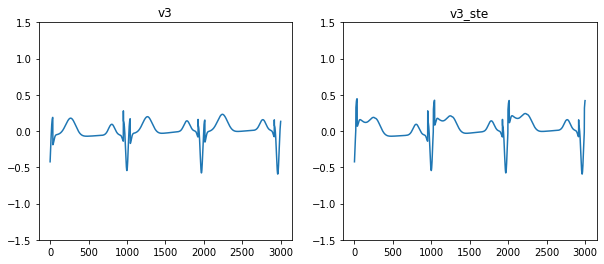

In [ ]:
tmp1 = generate_ecg_v3(ecg, q_peaks, qrs_segments, 
                       pattern='normal')
tmp2 = generate_ecg_v3(ecg, q_peaks, qrs_segments, 
                       pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(tmp1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v3")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(tmp2[3001:6001])
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v3_ste")

In [ ]:
# ecg_v4 : decrease S + scaled
def generate_ecg_v4(ecg, pattern='normal', **kwargs):

  new_ecg = ecg.copy()
  #===== augmentation =====#
  new_ecg = new_ecg*0.5

  #===== pattern =====#
  if pattern == 'normal':
    ecg_v4 = new_ecg
    return ecg_v4
  else :
    rst_segments = kwargs.get('rst_segments', None)
    ecg_v4 = new_ecg
    ecg_v4_ste = segment_aug_slope(ecg_v4, segments=rst_segments)
    return ecg_v4_ste


Text(0.5, 1.0, 'v4_ste')

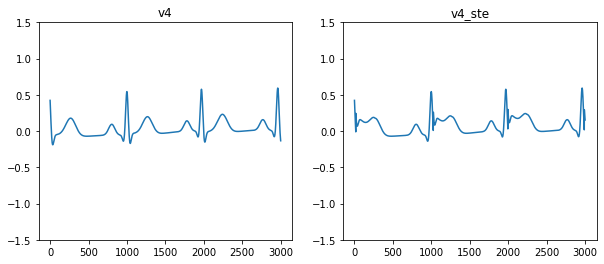

In [ ]:
tmp1 = generate_ecg_v4(ecg, pattern='normal')
tmp2 = generate_ecg_v4(ecg, pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(tmp1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v4")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(tmp2[3001:6001])
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v4_ste")

## Add Noise

In [ ]:
#===== setting =====#
duration = 10
sampling_rate = 1000
noise = 0
method = 'ecgsyn'
heart_rate = 60


#===== generate ecg =====#
ecg = nk.ecg_simulate(duration=duration, 
                      sampling_rate=sampling_rate, 
                      noise=noise, 
                      heart_rate=heart_rate,
                      method=method)


#===== get morphology information =====#
peaks = peaks_detected(ecg, sampling_rate=1000)

st_segments = get_segments(peaks, p1='ECG_S_Peaks', p2='ECG_T_Peaks')
tp_segments = get_segments(peaks, p1='ECG_T_Peaks', p2='ECG_P_Peaks') 

q_peaks = peaks['ECG_Q_Peaks']
qrs_segments = get_segments(peaks, p1='ECG_Q_Peaks', p2='ECG_S_Peaks')

rst_segments = get_segments(peaks, p1='ECG_R_Peaks', p2='ECG_T_Peaks')




In [ ]:
def addnoise_bw(seq, sampling_rate=1000):

  #===== gerate baseline wander noise =====#
  # set parameters (ref. BW Detection Threshold )
  F = random.choice([0.5, 1.0, 1.5, 2.0])   # No. of cycles per second, F = 500 Hz
  T = 10         # Time period, T = 2 ms
  Fs = sampling_rate   # No. of samples per second, Fs = 50 kHz
  Ts = 1./Fs       # Sampling interval, Ts = 20 us
  N = int(T/Ts)     # No. of samples for 2 ms, N = 100
  # generate 
  t = np.linspace(0, T, N)
  noise = np.sin(2*np.pi*F*t)*0.1
  # add noise
  new_seq = seq + noise

  return new_seq

Text(0.5, 1.0, 'v4_ste')

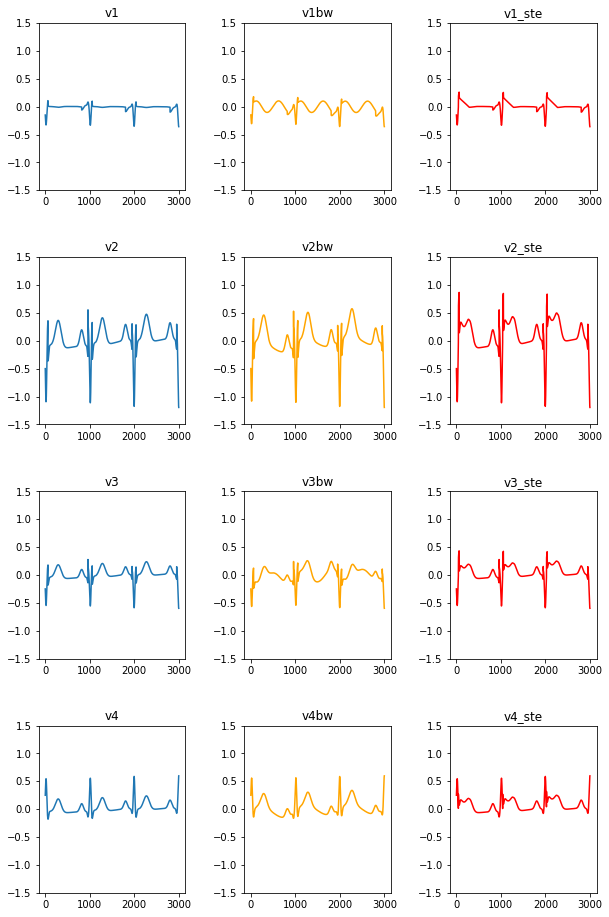

In [ ]:
# visualization 1 sample
v1 = generate_ecg_v1(ecg, st_segments, tp_segments, pattern='normal')
v1bw = addnoise_bw(v1, sampling_rate=1000)
v1_ste = generate_ecg_v1(ecg, st_segments, tp_segments, 
                         pattern='ste', rst_segments=rst_segments)

v2 = generate_ecg_v2(ecg, q_peaks, qrs_segments, pattern='normal')
v2bw = addnoise_bw(v2, sampling_rate=1000)
v2_ste = generate_ecg_v2(ecg, q_peaks, qrs_segments, 
                         pattern='ste', rst_segments=rst_segments)

v3 = generate_ecg_v3(ecg, q_peaks, qrs_segments, pattern='normal')
v3bw = addnoise_bw(v3, sampling_rate=1000)
v3_ste = generate_ecg_v3(ecg, q_peaks, qrs_segments, 
                         pattern='ste', rst_segments=rst_segments)

v4 = generate_ecg_v4(ecg, pattern='normal')
v4bw = addnoise_bw(v4, sampling_rate=1000)
v4_ste = generate_ecg_v4(ecg, pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(4,3,1)
ax1.plot(v1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v1")

ax2 = fig.add_subplot(4,3,2)
ax2.plot(v1bw[3001:6001], color='orange')
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v1bw")

ax3 = fig.add_subplot(4,3,3)
ax3.plot(v1_ste[3001:6001], color='red')
ax3.set(ylim=(-1.5, 1.5))
ax3.set_title("v1_ste")

ax4 = fig.add_subplot(4,3,4)
ax4.plot(v2[3001:6001])
ax4.set(ylim=(-1.5, 1.5))
ax4.set_title("v2")

ax5 = fig.add_subplot(4,3,5)
ax5.plot(v2bw[3001:6001], color='orange')
ax5.set(ylim=(-1.5, 1.5))
ax5.set_title("v2bw")

ax6 = fig.add_subplot(4,3,6)
ax6.plot(v2_ste[3001:6001], color='red')
ax6.set(ylim=(-1.5, 1.5))
ax6.set_title("v2_ste")

ax7 = fig.add_subplot(4,3,7)
ax7.plot(v3[3001:6001])
ax7.set(ylim=(-1.5, 1.5))
ax7.set_title("v3")

ax8 = fig.add_subplot(4,3,8)
ax8.plot(v3bw[3001:6001], color='orange')
ax8.set(ylim=(-1.5, 1.5))
ax8.set_title("v3bw")

ax9 = fig.add_subplot(4,3,9)
ax9.plot(v3_ste[3001:6001], color='red')
ax9.set(ylim=(-1.5, 1.5))
ax9.set_title("v3_ste")

ax10 = fig.add_subplot(4,3,10)
ax10.plot(v4[3001:6001])
ax10.set(ylim=(-1.5, 1.5))
ax10.set_title("v4")

ax11 = fig.add_subplot(4,3,11)
ax11.plot(v4bw[3001:6001], color='orange')
ax11.set(ylim=(-1.5, 1.5))
ax11.set_title("v4bw")

ax12 = fig.add_subplot(4,3,12)
ax12.plot(v4_ste[3001:6001], color='red')
ax12.set(ylim=(-1.5, 1.5))
ax12.set_title("v4_ste")


In [ ]:
def addnoise_ma(seq):

  # random position
  new_ecg = seq.copy()
  num1 = np.random.randint(int(new_ecg.shape[0]*0.25), int(new_ecg.shape[0]*0.75))
  num2 = np.random.randint(int(new_ecg.shape[0]*0.25), int(new_ecg.shape[0]*0.75))
  _start = min([num1, num2])
  _end = max([num1, num2])

  # generate noise
  noise1 = np.random.randn(new_ecg[:_start].shape[0])*0.05
  #noise2 = np.random.randn(new_ecg[_start:_end].shape[0])*0.02
  noise3 = np.random.randn(new_ecg[_end:].shape[0])*0.05

  # update values
  new_ecg[:_start] += noise1
  #new_ecg[_start:_end] += noise2
  new_ecg[_end:] += noise3

  return new_ecg

Text(0.5, 1.0, 'v4_ste')

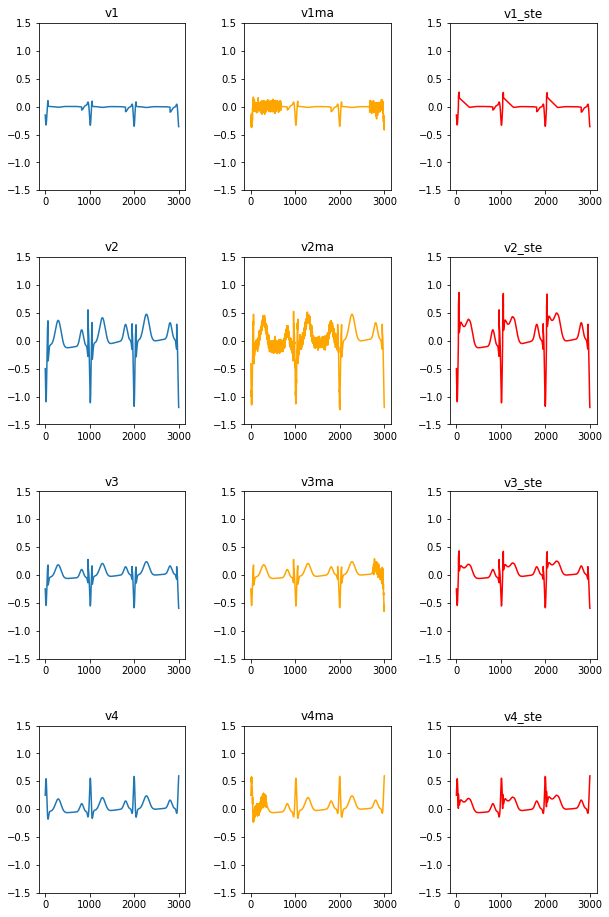

In [ ]:
# visualization 1 sample
v1 = generate_ecg_v1(ecg, st_segments, tp_segments, pattern='normal')
v1ma = addnoise_ma(v1)
v1_ste = generate_ecg_v1(ecg, st_segments, tp_segments, 
                         pattern='ste', rst_segments=rst_segments)

v2 = generate_ecg_v2(ecg, q_peaks, qrs_segments, pattern='normal')
v2ma = addnoise_ma(v2)
v2_ste = generate_ecg_v2(ecg, q_peaks, qrs_segments, 
                         pattern='ste', rst_segments=rst_segments)

v3 = generate_ecg_v3(ecg, q_peaks, qrs_segments, pattern='normal')
v3ma = addnoise_ma(v3)
v3_ste = generate_ecg_v3(ecg, q_peaks, qrs_segments, 
                         pattern='ste', rst_segments=rst_segments)

v4 = generate_ecg_v4(ecg, pattern='normal')
v4ma = addnoise_ma(v4)
v4_ste = generate_ecg_v4(ecg, pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(4,3,1)
ax1.plot(v1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v1")

ax2 = fig.add_subplot(4,3,2)
ax2.plot(v1ma[3001:6001], color='orange')
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v1ma")

ax3 = fig.add_subplot(4,3,3)
ax3.plot(v1_ste[3001:6001], color='red')
ax3.set(ylim=(-1.5, 1.5))
ax3.set_title("v1_ste")

ax4 = fig.add_subplot(4,3,4)
ax4.plot(v2[3001:6001])
ax4.set(ylim=(-1.5, 1.5))
ax4.set_title("v2")

ax5 = fig.add_subplot(4,3,5)
ax5.plot(v2ma[3001:6001], color='orange')
ax5.set(ylim=(-1.5, 1.5))
ax5.set_title("v2ma")

ax6 = fig.add_subplot(4,3,6)
ax6.plot(v2_ste[3001:6001], color='red')
ax6.set(ylim=(-1.5, 1.5))
ax6.set_title("v2_ste")

ax7 = fig.add_subplot(4,3,7)
ax7.plot(v3[3001:6001])
ax7.set(ylim=(-1.5, 1.5))
ax7.set_title("v3")

ax8 = fig.add_subplot(4,3,8)
ax8.plot(v3ma[3001:6001], color='orange')
ax8.set(ylim=(-1.5, 1.5))
ax8.set_title("v3ma")

ax9 = fig.add_subplot(4,3,9)
ax9.plot(v3_ste[3001:6001], color='red')
ax9.set(ylim=(-1.5, 1.5))
ax9.set_title("v3_ste")

ax10 = fig.add_subplot(4,3,10)
ax10.plot(v4[3001:6001])
ax10.set(ylim=(-1.5, 1.5))
ax10.set_title("v4")

ax11 = fig.add_subplot(4,3,11)
ax11.plot(v4ma[3001:6001], color='orange')
ax11.set(ylim=(-1.5, 1.5))
ax11.set_title("v4ma")

ax12 = fig.add_subplot(4,3,12)
ax12.plot(v4_ste[3001:6001], color='red')
ax12.set(ylim=(-1.5, 1.5))
ax12.set_title("v4_ste")


In [ ]:
def addnoise_gn(seq):

  new_ecg = seq.copy()
  noise = np.random.randn(new_ecg.shape[0])*0.05
  new_ecg += noise

  return new_ecg


Text(0.5, 1.0, 'v4_ste')

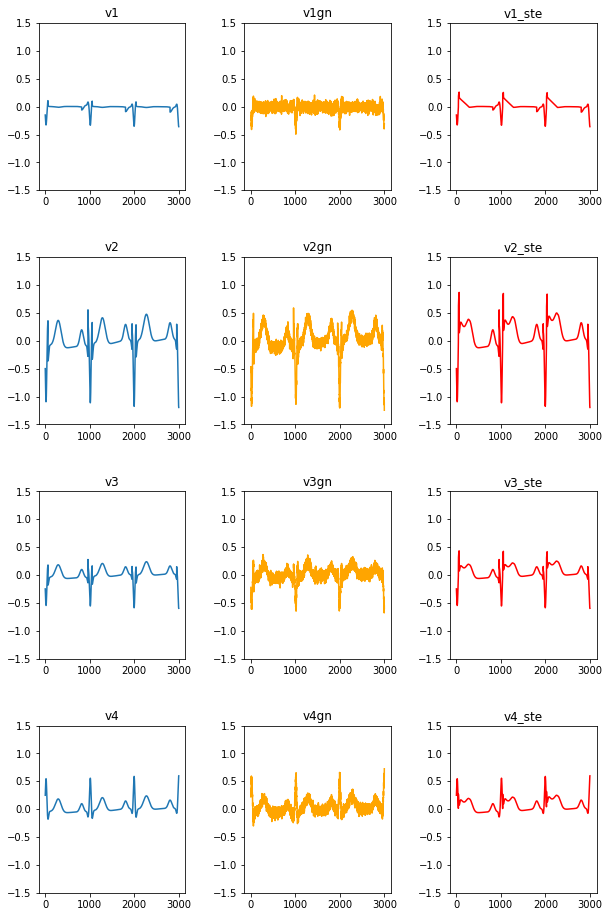

In [ ]:
# visualization 1 sample
v1 = generate_ecg_v1(ecg, st_segments, tp_segments, pattern='normal')
v1gn = addnoise_gn(v1)
v1_ste = generate_ecg_v1(ecg, st_segments, tp_segments, 
                         pattern='ste', rst_segments=rst_segments)

v2 = generate_ecg_v2(ecg, q_peaks, qrs_segments, pattern='normal')
v2gn = addnoise_gn(v2)
v2_ste = generate_ecg_v2(ecg, q_peaks, qrs_segments, 
                         pattern='ste', rst_segments=rst_segments)

v3 = generate_ecg_v3(ecg, q_peaks, qrs_segments, pattern='normal')
v3gn = addnoise_gn(v3)
v3_ste = generate_ecg_v3(ecg, q_peaks, qrs_segments, 
                         pattern='ste', rst_segments=rst_segments)

v4 = generate_ecg_v4(ecg, pattern='normal')
v4gn = addnoise_gn(v4)
v4_ste = generate_ecg_v4(ecg, pattern='ste', rst_segments=rst_segments)


fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(4,3,1)
ax1.plot(v1[3001:6001])
ax1.set(ylim=(-1.5, 1.5))
ax1.set_title("v1")

ax2 = fig.add_subplot(4,3,2)
ax2.plot(v1gn[3001:6001], color='orange')
ax2.set(ylim=(-1.5, 1.5))
ax2.set_title("v1gn")

ax3 = fig.add_subplot(4,3,3)
ax3.plot(v1_ste[3001:6001], color='red')
ax3.set(ylim=(-1.5, 1.5))
ax3.set_title("v1_ste")

ax4 = fig.add_subplot(4,3,4)
ax4.plot(v2[3001:6001])
ax4.set(ylim=(-1.5, 1.5))
ax4.set_title("v2")

ax5 = fig.add_subplot(4,3,5)
ax5.plot(v2gn[3001:6001], color='orange')
ax5.set(ylim=(-1.5, 1.5))
ax5.set_title("v2gn")

ax6 = fig.add_subplot(4,3,6)
ax6.plot(v2_ste[3001:6001], color='red')
ax6.set(ylim=(-1.5, 1.5))
ax6.set_title("v2_ste")

ax7 = fig.add_subplot(4,3,7)
ax7.plot(v3[3001:6001])
ax7.set(ylim=(-1.5, 1.5))
ax7.set_title("v3")

ax8 = fig.add_subplot(4,3,8)
ax8.plot(v3gn[3001:6001], color='orange')
ax8.set(ylim=(-1.5, 1.5))
ax8.set_title("v3gn")

ax9 = fig.add_subplot(4,3,9)
ax9.plot(v3_ste[3001:6001], color='red')
ax9.set(ylim=(-1.5, 1.5))
ax9.set_title("v3_ste")

ax10 = fig.add_subplot(4,3,10)
ax10.plot(v4[3001:6001])
ax10.set(ylim=(-1.5, 1.5))
ax10.set_title("v4")

ax11 = fig.add_subplot(4,3,11)
ax11.plot(v4gn[3001:6001], color='orange')
ax11.set(ylim=(-1.5, 1.5))
ax11.set_title("v4gn")

ax12 = fig.add_subplot(4,3,12)
ax12.plot(v4_ste[3001:6001], color='red')
ax12.set(ylim=(-1.5, 1.5))
ax12.set_title("v4_ste")

## Simulate Dataset

In [ ]:
# simulate dataset
def generate_ecg_dataset(pattern='normal', addnoise='none', n_samples=10):
  '''
    generate ECG dataset
    pattern : 'normal', 'ste'
    addnoise : 'none', 'bw', 'ma', 'gn'
    n_samples : number of samples
  '''

  #===== setting =====#
  duration = 10
  sampling_rate = 1000
  noise = 0
  method = 'ecgsyn' 
  heart_rate = np.random.randint(60, 100)

  pattern = pattern
  addnoise = 'none'
  n_samples = n_samples

  #===== generate data =====#
  data = []
  for i in range(n_samples):
    ecg = nk.ecg_simulate(duration=duration, 
                          sampling_rate=sampling_rate, 
                          noise=noise, 
                          heart_rate=heart_rate, 
                          method=method)
    # get morphology 
    peaks = peaks_detected(ecg, sampling_rate=1000)
    st_segments = get_segments(peaks, p1='ECG_S_Peaks', p2='ECG_T_Peaks')
    tp_segments = get_segments(peaks, p1='ECG_T_Peaks', p2='ECG_P_Peaks') 
    q_peaks = peaks['ECG_Q_Peaks']
    qrs_segments = get_segments(peaks, p1='ECG_Q_Peaks', p2='ECG_S_Peaks')
    rst_segments = get_segments(peaks, p1='ECG_R_Peaks', p2='ECG_T_Peaks')
    # generate v1-v4
    if pattern == 'normal':
      v1 = generate_ecg_v1(ecg, st_segments, tp_segments, pattern=pattern)
      v2 = generate_ecg_v2(ecg, q_peaks, qrs_segments, pattern=pattern)
      v3 = generate_ecg_v3(ecg, q_peaks, qrs_segments, pattern=pattern)
      v4 = generate_ecg_v4(ecg, pattern=pattern)
    else :
      v1 = generate_ecg_v1(ecg, st_segments, tp_segments, 
                          pattern='ste', rst_segments=rst_segments)
      v2 = generate_ecg_v2(ecg, q_peaks, qrs_segments, 
                          pattern='ste', rst_segments=rst_segments)
      v3 = generate_ecg_v3(ecg, q_peaks, qrs_segments, 
                          pattern='ste', rst_segments=rst_segments)
      v4 = generate_ecg_v4(ecg, pattern='ste', rst_segments=rst_segments)

    smp_data = {'id': i,
                'v1': v1, 
                'v2': v2, 
                'v3': v3, 
                'v4': v4}

    data.append(smp_data)

  # store data in DataFrame
  df = pd.DataFrame(data)

  # addnoise
  if addnoise == 'none':
    return df

  elif addnoise == 'bw':
    df_bw = df.apply(lambda x: addnoise_bw(x, sampling_rate=1000))
    return df_bw

  elif addnoise == 'ma':
    df_ma = df.apply(lambda x: addnoise_ma(x))
    return df_ma

  elif addnoise == 'gn':
    df_gn = df.apply(lambda x: addnoise_gn(x))
    return df_gn  



In [ ]:
tmp = generate_ecg_dataset(pattern='normal', addnoise='none', n_samples=10)


In [ ]:
tmp_ste = generate_ecg_dataset(pattern='ste', addnoise='none', n_samples=1000)


In [ ]:
tmpbw = generate_ecg_dataset(pattern='normal', addnoise='bw', n_samples=10)


Text(0.5, 1.0, 'v1_ste of sample 1')

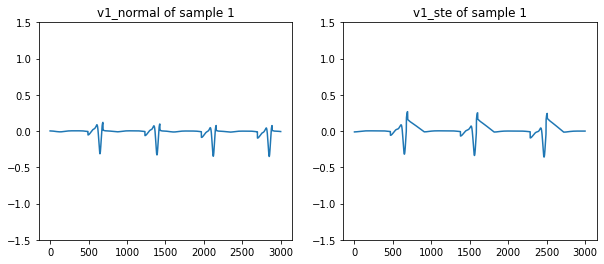

In [ ]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(tmp['v1'][0][3001:6001])
ax1.set(ylim=([-1.5, 1.5]))
ax1.set_title('v1_normal of sample 1')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(tmp_ste['v1'][0][3001:6001])
ax2.set(ylim=([-1.5, 1.5]))
ax2.set_title('v1_ste of sample 1')

Text(0.5, 1.0, 'v2bw_normal of sample 1')

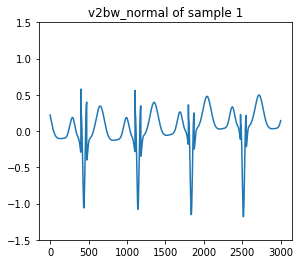

In [ ]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(tmpbw['v2'][9][3001:6001])
ax1.set(ylim=([-1.5, 1.5]))
ax1.set_title('v2bw_normal of sample 1')